<a href="https://colab.research.google.com/github/Vladoskn/Acne-detection-and-removal/blob/main/Model_1_(%D0%94%D0%B5%D0%B1%D0%B8%D1%82%D1%8B%2C_%D0%B4%D0%B0%D0%B2%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F%2C_%D1%84%D0%B8%D0%BB%D1%8C%D1%82%D1%80%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B2%D0%BE%D0%B9%D1%81%D1%82%D0%B2%D0%B0)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output

!pip install xlsxwriter
!pip install -U scikit-learn

clear_output()

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import xlrd
import sklearn
import os
import re
sns.set()
%matplotlib inline
import datetime as dt
from datetime import datetime
from copy import copy
import os
import re
import warnings
warnings.filterwarnings('ignore')
import pickle as pkl
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import operator
from datetime import timedelta
from collections import defaultdict
from dateutil.relativedelta import relativedelta
from sklearn import pipeline, preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import average_precision_score
from sklearn.metrics import make_scorer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.base import clone
from sklearn import preprocessing
# from imblearn.over_sampling import SMOTE
from sklearn.metrics import plot_confusion_matrix
from functools import reduce
from sklearn.neighbors import KDTree
from scipy.optimize import curve_fit
from sklearn.preprocessing import Normalizer
import xlsxwriter
from sklearn.linear_model import LogisticRegression

from IPython.display import clear_output
from pandas.tseries.offsets import DateOffset
from sklearn.ensemble import StackingClassifier

# Downloading data (Colab)

In [ ]:
def download_from_gdrive(gdrive_id, filename):
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$gdrive_id -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$gdrive_id -O $filename && rm -rf /tmp/cookies.txt

In [ ]:
GDRIVE_ID = '1Krh5PiWtPA84wVqgCDrMrPEbghxGY2D6'
FILE_IDS_NAME = 'file_ids.txt'

download_from_gdrive(GDRIVE_ID, FILE_IDS_NAME)

FILE_IDS = {}
with open(FILE_IDS_NAME, 'r') as f:
    for line in f:
        name, gid = line.strip().split('\t')
        FILE_IDS[name] = gid

clear_output()

In [ ]:
DATA_DIR = 'Upload'
fname = f'{DATA_DIR}.zip'
download_from_gdrive(FILE_IDS[fname], fname)
!unzip -o {DATA_DIR}
clear_output()

DATA_DIR = 'preproc'
fname = f'{DATA_DIR}.pkl'
download_from_gdrive(FILE_IDS[fname], fname)

DATA_DIR = 'final_table_upd'
fname = f'{DATA_DIR}.xlsx'
download_from_gdrive(FILE_IDS[fname], fname)
clear_output()

# Preprocessing

In [ ]:
GDRIVE_ID = '1Ze2kEcZrYBaPZt_X9Rc9Xeu-hCFCOF0R'
FILE_PREPROC = 'preprocessor.py'

download_from_gdrive(GDRIVE_ID, FILE_PREPROC)
clear_output()

from preprocessor import Preproc

In [ ]:
'''Uncomment this cell to run preprocessor'''

# model = Preproc('initial_sorted')
# showbd = model.forward(process_fields = None, no_GTM_surr = True, prGTM_surr = False) 

# with open('preproc.pkl', 'wb') as f:
#     pkl.dump(model, f)

'Uncomment this cell to run preprocessor'

In [ ]:
'''Using saved preprocessor'''

with open('preproc.pkl', 'rb') as f:
    model = pkl.load(f)

In [ ]:
ft = model.final_table

# ft = pd.read_excel('final table.xlsx')
ft[['Координата X', 'Координата Y', 'Время с ГТМ', 'Время с запуска']] = ft[['Координата X', 'Координата Y', 'Время с ГТМ', 'Время с запуска']].astype(float)

print(ft[ft['ГТМ']==1].shape)
print(ft[ft['ГТМ']==0].shape)

(2712, 75)
(6835, 75)


In [ ]:
ft = ft[ft['Дата начала'] > pd.Timestamp(2004, 1, 1)]
print(ft[ft['ГТМ']==1].shape)
print(ft[ft['ГТМ']==0].shape)

(2417, 75)
(5777, 75)


# Experiments

In [ ]:
def CreateBalancedSampleWeights(y_train, largest_class_weight_coef):
    classes = np.unique(y_train)
    classes.sort()
    class_samples = np.bincount(y_train)
    total_samples = class_samples.sum()
    n_classes = len(class_samples)
    weights = total_samples / (n_classes * class_samples * 1.0)
    class_weight_dict = {key : value for (key, value) in zip(classes, weights)}
    class_weight_dict[classes[1]] = class_weight_dict[classes[1]] * largest_class_weight_coef
    sample_weights = [class_weight_dict[y] for y in y_train]

    return sample_weights

In [ ]:
dropcol = ['Дата начала', 'Скважина', 'Пласт']

data_1 = ft.drop(columns = dropcol)
data_1.reset_index(drop = True, inplace = True)

n_sel = 6
selection = [
             'Н_Дебит-01', 'Ж_Дебит-01', 'P_заб-01', 'P_пласт-01',
             'Н_Дебит-02', 'Ж_Дебит-02', 'P_заб-02', 'P_пласт-02',
             'Н_Дебит-03', 'Ж_Дебит-03', 'P_заб-03', 'P_пласт-03',
             'Н_Дебит-04', 'Ж_Дебит-04', 'P_заб-04', 'P_пласт-04',
             'Н_Дебит-05', 'Ж_Дебит-05', 'P_заб-05', 'P_пласт-05',
             'Н_Дебит-06', 'Ж_Дебит-06', 'P_заб-06', 'P_пласт-06',
#              'Н_Дебит-07', 'Ж_Дебит-07', 'P_заб-07', 'P_пласт-07',
#              'Н_Дебит-08', 'Ж_Дебит-08', 'P_заб-08', 'P_пласт-08',
#              'Н_Дебит-09', 'Ж_Дебит-09', 'P_заб-09', 'P_пласт-09',
#              'Н_Дебит-10', 'Ж_Дебит-10', 'P_заб-10', 'P_пласт-10',
#              'Н_Дебит-11', 'Ж_Дебит-11', 'P_заб-11', 'P_пласт-11',
#              'Н_Дебит-12', 'Ж_Дебит-12', 'P_заб-12', 'P_пласт-12'
                ]

additional_features = [
    'Ро', 'Пористость','Проницаемость','Глинистость','Нефтенасыщенность', 
#     'decay',
#     'Время с ГТМ', 
#     'Время с запуска',
#     'Ро окружение', 'Пористость окружение','Проницаемость окружение','Глинистость окружение','Нефтенасыщенность окружение'
#     'a', 'b','a_Ж', 'b_Ж'
]

data_1['decay'] = data_1['Н_Дебит-01']/data_1.iloc[:, (data_1.columns.str.contains('Н_'))&(data_1.columns != 'Н_Дебит-01')].max(axis = 1)
data_2 = data_1[data_1[sorted([s for s in selection if ('Дебит' in s) | ('заб' in s)])].ne(0).all(axis=1)][sorted(selection) + additional_features + ['Мероприятие','ГТМ']]
data_2.reset_index(drop = True, inplace = True)

print(data_2[data_2['ГТМ']==1].shape)
print(data_2[data_2['ГТМ']==0].shape)
print(data_2.shape)

(1757, 31)
(3065, 31)
(4822, 31)


In [ ]:
data_2

,P_заб-01,P_заб-02,P_заб-03,P_заб-04,P_заб-05,P_заб-06,P_пласт-01,P_пласт-02,P_пласт-03,P_пласт-04,P_пласт-05,P_пласт-06,Ж_Дебит-01,Ж_Дебит-02,Ж_Дебит-03,Ж_Дебит-04,Ж_Дебит-05,Ж_Дебит-06,Н_Дебит-01,Н_Дебит-02,Н_Дебит-03,Н_Дебит-04,Н_Дебит-05,Н_Дебит-06,Ро,Пористость,Проницаемость,Глинистость,Нефтенасыщенность,Мероприятие,ГТМ
0,110.651614,111.684886,111.602793,117.512781,113.541822,105.099804,163.000,163.000,163.000,163.000,163.000,163.000,125.867,124.387,123.200,122.064,121.795,119.967,8.578,8.672,8.961,7.459,7.993,6.850,0.957513,20.814508,73.904663,0.000000,55.449223,Эксплуатация,0
1,110.576954,110.651614,111.684886,111.602793,117.512781,113.541822,163.000,163.000,163.000,163.000,163.000,163.000,126.871,125.867,124.387,123.200,122.064,121.795,6.238,8.578,8.672,8.961,7.459,7.993,0.957513,20.814508,73.904663,0.000000,55.449223,Эксплуатация,0
2,110.781634,110.576954,110.651614,111.684886,111.602793,117.512781,163.000,163.000,163.000,163.000,163.000,163.000,127.097,126.871,125.867,124.387,123.200,122.064,8.406,6.238,8.578,8.672,8.961,7.459,0.957513,20.814508,73.904663,0.000000,55.449223,Эксплуатация,0
3,120.162974,116.385211,110.781634,110.576954,110.651614,111.684886,164.000,163.000,163.000,163.000,163.000,163.000,127.607,126.714,127.097,126.871,125.867,124.387,8.832,8.335,8.406,6.238,8.578,8.672,0.957513,20.814508,73.904663,0.000000,55.449223,Эксплуатация,0
4,121.999056,120.162974,116.385211,110.781634,110.576954,110.651614,164.000,164.000,163.000,163.000,163.000,163.000,128.031,127.607,126.714,127.097,126.871,125.867,7.793,8.832,8.335,8.406,6.238,8.578,0.957513,20.814508,73.904663,0.000000,55.449223,Эксплуатация,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4817,32.039168,31.953934,32.819253,32.867333,32.825088,31.868064,162.995,162.995,154.995,154.995,154.995,240.000,17.200,16.419,24.000,29.290,35.000,11.400,4.346,4.049,10.008,10.148,10.217,2.860,10.218719,0.000000,0.000000,0.000000,0.000000,ОПЗ,1
4818,78.439486,69.023960,81.214362,60.203758,82.305188,85.271066,220.000,220.000,220.000,220.000,220.000,220.000,15.000,18.032,20.607,15.806,11.032,16.567,8.001,9.655,12.375,9.954,7.424,8.961,7.548966,14.335172,5.797931,0.000000,24.105517,ОПЗ,1
4819,49.998794,89.061221,61.165220,91.432718,61.519847,105.432036,244.395,244.395,244.395,244.395,244.395,244.395,74.613,79.733,84.129,80.893,89.871,82.968,3.453,3.805,3.987,1.043,3.062,1.721,9.234507,10.125352,4.222535,0.000000,38.614085,ОПЗ,1
4820,55.488006,54.240369,58.837826,64.355209,63.793078,58.026364,153.996,153.996,153.996,154.997,154.997,154.997,9.260,8.000,11.097,11.571,11.065,6.774,4.076,4.412,4.826,5.166,5.068,2.884,7.004959,14.609917,8.523967,8.466942,42.585950,ГРП,1


,Мероприятие
Эксплуатация,3065
ГРП,1391
ОПЗ,358
ЗБС,8


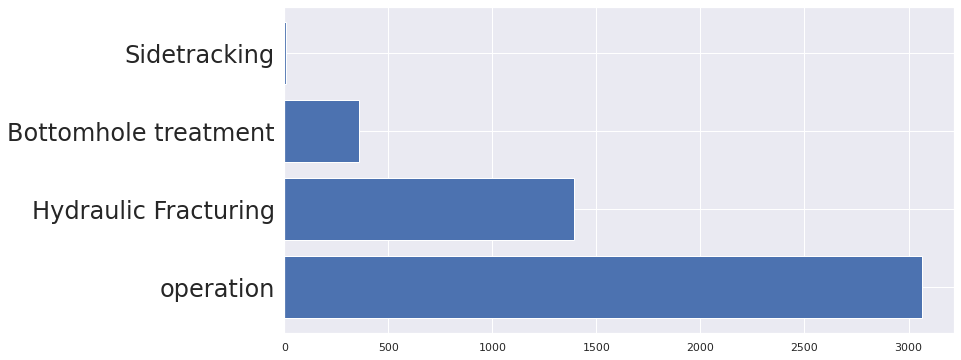

In [ ]:
graph = pd.DataFrame(data_2["Мероприятие"].value_counts())
plt.figure(figsize=(12,6))
plt.barh(['operation', 'Hydraulic Fracturing', 'Bottomhole treatment', 'Sidetracking'], graph["Мероприятие"])
plt.yticks(fontsize=24)
graph

In [ ]:
cv = StratifiedKFold(n_splits = 3, shuffle=True, random_state = 43)

parameters_grid = {
    'RF':{
       'model_fitting__n_estimators': [300, 500], 
       'model_fitting__max_depth': np.arange(5, 8).tolist(), 
    },
    'XGB':{
        'model_fitting__n_estimators': [300, 500],
        'model_fitting__max_depth': np.arange(5, 8).tolist(), 
        'model_fitting__learning_rate': (1/10**np.arange(1, 4, 1)).tolist(),
        'model_fitting__reg_lambda': [0.1, 0.5, 1],
        'model_fitting__gamma': [0, 1, 5]
    },
    'KNN':{
        'model_fitting__n_neighbors': [10, 20, 30, 50, 100, 150],
        'model_fitting__weights': ['distance', 'uniform'],
        'model_fitting__leaf_size' : [10, 20, 30, 50]
    },
    'SVC':{
        'model_fitting__kernel': ['poly'], #, 'rbf'
        'model_fitting__C': [10**i for i in range(-3,1)],
        'model_fitting__gamma': [0.1, 1, 10, 50, 'scale'],
    }
}

X = data_2.drop(columns = ['ГТМ', 'Мероприятие'])
y = data_2[['ГТМ']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify = y)



categorical_feature_mask = X_train.dtypes==object
numeric_feature_mask = (X_train.dtypes==float) |  (X_train.dtypes==int)
binary_feature_mask = X_train.dtypes==bool

categorical_data_columns = X_train.columns[categorical_feature_mask].tolist()
numeric_data_columns = X_train.columns[numeric_feature_mask].tolist()
binary_data_columns = X_train.columns[binary_feature_mask].tolist()

categorical_data_indices = np.array([(column in categorical_data_columns) for column in X_train.columns], dtype = bool)
numeric_data_indices = np.array([(column in numeric_data_columns) for column in X_train.columns], dtype = bool)
binary_data_indices = np.array([(column in binary_data_columns) for column in X_train.columns], dtype = bool)


largest_class_weight_coef = max(np.bincount(y_train.to_numpy().reshape(1,-1)[0]))/y_train.shape[0]
train_sample_weight = CreateBalancedSampleWeights(y_train.to_numpy().reshape(1,-1)[0], largest_class_weight_coef=largest_class_weight_coef)


RF = RandomForestClassifier(class_weight = "balanced", random_state=23, n_jobs = -1)
XGB = XGBClassifier(random_state=5, importance_type = 'weight', n_jobs=-1, colsample_bytree = 0.8, objective= 'binary:logistic')
k_neighbors = KNeighborsClassifier(n_jobs = -1)
support_vector = SVC(random_state = 3)

mybase = [
          k_neighbors,
          RF,
          XGB, 
          support_vector
         ]
labels = [
          'KNN',
          'RF',
          'XGB',
          'SVC'
          ]

best_params = {}
best_score = {}
best_est = {}


for clf, label in zip(mybase, labels):
    clf_pipe = pipeline.Pipeline(steps = [       
        ('feature_processing', pipeline.FeatureUnion(transformer_list = [ 
                #binary
                ('formation_variables_processing', pipeline.Pipeline(steps = [
                    ('selecting', preprocessing.FunctionTransformer(lambda data: data.iloc[:, binary_data_indices].astype(int)))          
                            ])),

                #numeric
                ('fp_variables_processing', pipeline.Pipeline(steps = [
                    ('selecting', preprocessing.FunctionTransformer(lambda data: data.iloc[:, numeric_data_indices])),
                    ('scaling', preprocessing.MinMaxScaler())            
                            ])),
            ])),
        ('model_fitting', clf)
        ]
    )    
    grid_cv = GridSearchCV(clf_pipe, parameters_grid[label], scoring=make_scorer(metrics.recall_score), cv = cv, verbose = 10, refit = True)
    if label == 'XGB':
        grid_cv.fit(X_train, y_train, model_fitting__sample_weight = train_sample_weight)
    else:
        grid_cv.fit(X_train, y_train)
    best_params[label] = grid_cv.best_params_
    best_score[label] = grid_cv.score(X_test, y_test)
    best_est[label]=grid_cv.best_estimator_

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3; 1/48] START model_fitting__leaf_size=10, model_fitting__n_neighbors=10, model_fitting__weights=distance
[CV 1/3; 1/48] END model_fitting__leaf_size=10, model_fitting__n_neighbors=10, model_fitting__weights=distance; total time=   0.2s
[CV 2/3; 1/48] START model_fitting__leaf_size=10, model_fitting__n_neighbors=10, model_fitting__weights=distance
[CV 2/3; 1/48] END model_fitting__leaf_size=10, model_fitting__n_neighbors=10, model_fitting__weights=distance; total time=   0.2s
[CV 3/3; 1/48] START model_fitting__leaf_size=10, model_fitting__n_neighbors=10, model_fitting__weights=distance
[CV 3/3; 1/48] END model_fitting__leaf_size=10, model_fitting__n_neighbors=10, model_fitting__weights=distance; total time=   0.2s
[CV 1/3; 2/48] START model_fitting__leaf_size=10, model_fitting__n_neighbors=10, model_fitting__weights=uniform
[CV 1/3; 2/48] END model_fitting__leaf_size=10, model_fitting__n_neighbors=10, model_fitting__

In [ ]:
best_params

{'KNN': {'model_fitting__leaf_size': 10,
  'model_fitting__n_neighbors': 100,
  'model_fitting__weights': 'distance'},
 'RF': {'model_fitting__max_depth': 5, 'model_fitting__n_estimators': 300},
 'SVC': {'model_fitting__C': 0.001,
  'model_fitting__gamma': 50,
  'model_fitting__kernel': 'poly'},
 'XGB': {'model_fitting__gamma': 0,
  'model_fitting__learning_rate': 0.01,
  'model_fitting__max_depth': 5,
  'model_fitting__n_estimators': 500,
  'model_fitting__reg_lambda': 0.1}}

In [ ]:
# best_params = {'KNN': {'model_fitting__leaf_size': 10,
#   'model_fitting__n_neighbors': 100,
#   'model_fitting__weights': 'distance'},
#  'RF': {'model_fitting__max_depth': 5, 'model_fitting__n_estimators': 300},
#  'SVC': {'model_fitting__C': 0.001,
#   'model_fitting__gamma': 50,
#   'model_fitting__kernel': 'poly'},
#  'XGB': {'model_fitting__gamma': 0,
#   'model_fitting__learning_rate': 0.01,
#   'model_fitting__max_depth': 5,
#   'model_fitting__n_estimators': 500,
#   'model_fitting__reg_lambda': 0.1}}

KNN 	  |  TN =  774 FN =  114 FP =  146 TP =  413
RF 	  |  TN =  703 FN =  88 FP =  217 TP =  439
XGB 	  |  TN =  806 FN =  117 FP =  114 TP =  410
SVC 	  |  TN =  680 FN =  77 FP =  240 TP =  450


,KNN,RF,XGB,SVC
precision,0.739,0.669,0.782,0.652
recall,0.784,0.833,0.778,0.854
average precision,0.658,0.618,0.690,0.610


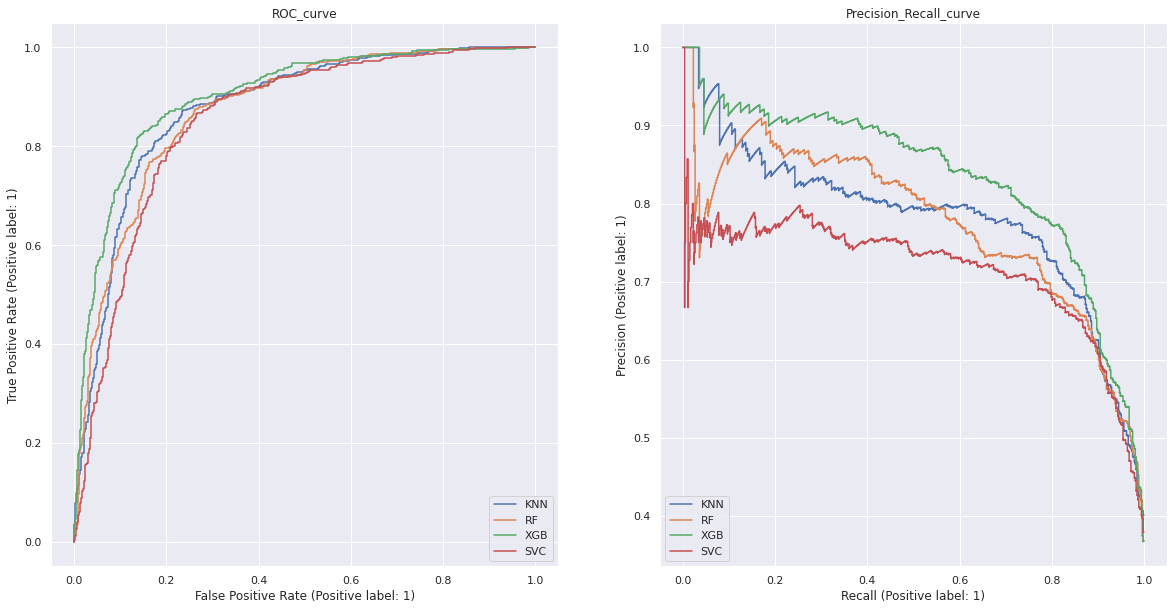

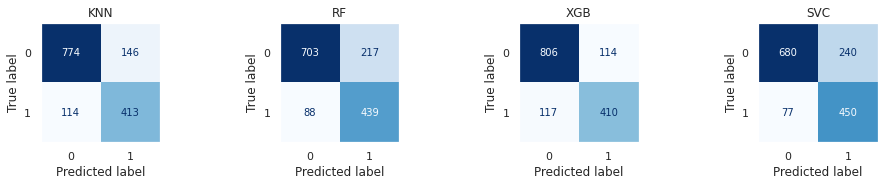

In [ ]:
RF = best_est['RF']
XGB = best_est['XGB']
k_neighbors = best_est['KNN']
support_vector = best_est['SVC']

mybase = [
          k_neighbors,
          RF,
          XGB, 
          support_vector
         ]
labels = [
          'KNN',
          'RF',
          'XGB',
          'SVC'
          ]

base_scores1 = {}
base_scores2 = {}
base_scores3 = {}
clf_pipel={}

fig, ax = plt.subplots(1, 2, figsize = (20,10))
figs, axs = plt.subplots(1, len(labels), figsize = (15,40))
plt.subplots_adjust(wspace = 1)

for indx, (clf, label) in enumerate(zip(mybase, labels)):
    y_pred = clf.predict(X_test)
    base_scores1[label] = metrics.precision_score(y_test, y_pred)
    base_scores2[label] = metrics.recall_score(y_test, y_pred)
    base_scores3[label] = metrics.average_precision_score(y_test, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
    print(label,'\t' , ' | ', 'TN = ', tn, 'FN = ', fn, 'FP = ', fp,  'TP = ', tp)
    metrics.plot_roc_curve(clf, X_test, y_test, ax = ax[0], label = label)
    metrics.plot_precision_recall_curve(clf, X_test, y_test, ax = ax[1], label = label)
    plot_confusion_matrix(clf, X_test, y_test, cmap = plt.cm.Blues, values_format = '.3g', ax = axs[indx], colorbar = False)
    axs[indx].grid(False)
    axs[indx].set_title(label)
ax[0].set_title('ROC_curve')
ax[1].set_title('Precision_Recall_curve')
tabble1 = round(pd.DataFrame(base_scores1, index=['precision']),3)
tabble2 = round(pd.DataFrame(base_scores2, index=['recall']),3)
tabble3 = round(pd.DataFrame(base_scores3, index=['average precision']),3)
display(pd.concat([tabble1, pd.concat([tabble2, tabble3])]))

set_params + stacked

KNN 	  |  TN =  774 FN =  114 FP =  146 TP =  413
RF 	  |  TN =  703 FN =  88 FP =  217 TP =  439
XGB 	  |  TN =  806 FN =  117 FP =  114 TP =  410
SVC 	  |  TN =  680 FN =  77 FP =  240 TP =  450


,KNN,RF,XGB,SVC,Stacked
precision,0.739,0.669,0.782,0.652,0.800
recall,0.784,0.833,0.778,0.854,0.782
average precision,0.658,0.618,0.690,0.610,0.705


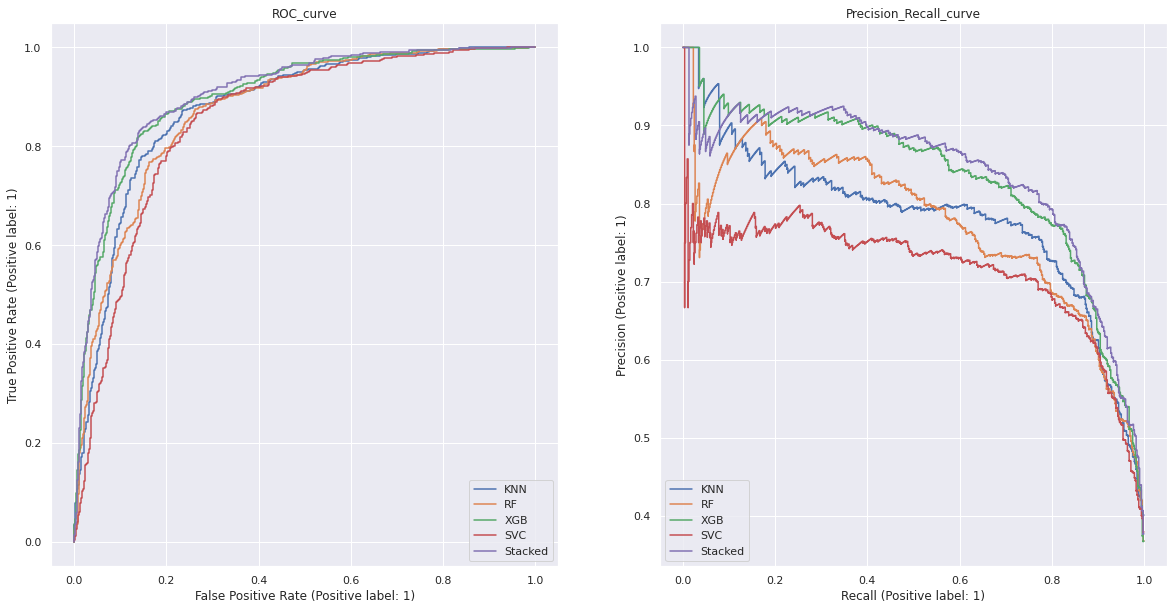

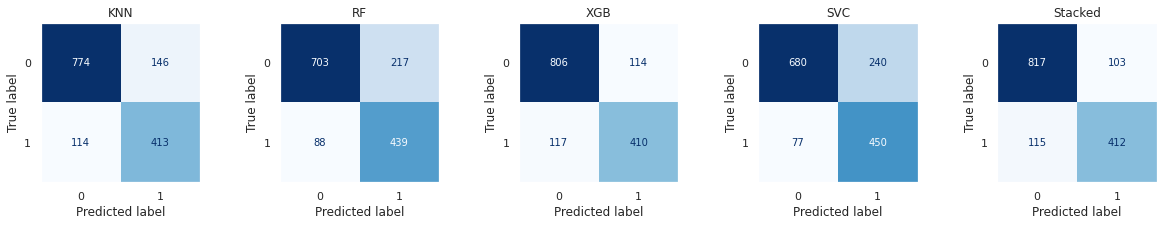

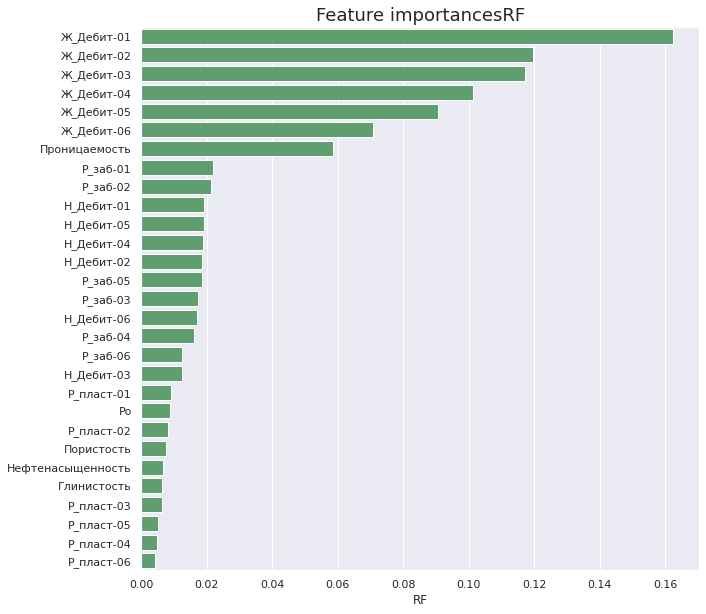

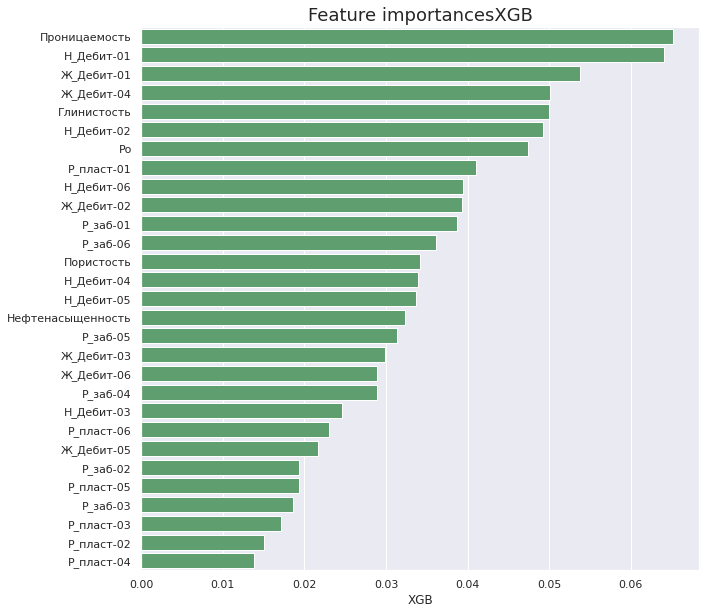

In [ ]:
X = data_2.drop(columns = ['ГТМ', 'Мероприятие'])
y = data_2[['ГТМ']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify = y)



categorical_feature_mask = X_train.dtypes==object
numeric_feature_mask = (X_train.dtypes==float) |  (X_train.dtypes==int)
binary_feature_mask = X_train.dtypes==bool

categorical_data_columns = X_train.columns[categorical_feature_mask].tolist()
numeric_data_columns = X_train.columns[numeric_feature_mask].tolist()
binary_data_columns = X_train.columns[binary_feature_mask].tolist()

categorical_data_indices = np.array([(column in categorical_data_columns) for column in X_train.columns], dtype = bool)
numeric_data_indices = np.array([(column in numeric_data_columns) for column in X_train.columns], dtype = bool)
binary_data_indices = np.array([(column in binary_data_columns) for column in X_train.columns], dtype = bool)


largest_class_weight_coef = max(np.bincount(y_train.to_numpy().reshape(1,-1)[0]))/y_train.shape[0]
train_sample_weight = CreateBalancedSampleWeights(y_train.to_numpy().reshape(1,-1)[0], largest_class_weight_coef=largest_class_weight_coef)


RF = RandomForestClassifier(class_weight = "balanced", random_state=23, n_jobs = -1)
XGB = XGBClassifier(random_state=5, importance_type = 'weight', n_jobs=-1, colsample_bytree = 0.8, objective= 'binary:logistic')
k_neighbors = KNeighborsClassifier(n_jobs = -1)
support_vector = SVC(random_state = 3)

mybase = [
          k_neighbors,
          RF,
          XGB, 
          support_vector
         ]
labels = [
          'KNN',
          'RF',
          'XGB',
          'SVC'
          ]

base_scores1 = {}
base_scores2 = {}
base_scores3 = {}
clf_pipel={}

fig, ax = plt.subplots(1, 2, figsize = (20,10))
figs, axs = plt.subplots(1, len(labels)+1, figsize = (20,6))
plt.subplots_adjust(wspace = 0.5)
for indx, (clf, label) in enumerate(zip(mybase, labels)):
    clf_pipel[label] = pipeline.Pipeline(steps = [       
        ('feature_processing', pipeline.FeatureUnion(transformer_list = [ 
                #binary
                ('formation_variables_processing', pipeline.Pipeline(steps = [
                    ('selecting', preprocessing.FunctionTransformer(lambda data: data.iloc[:, binary_data_indices]))          
                            ])),

                #numeric
                ('fp_variables_processing', pipeline.Pipeline(steps = [
                    ('selecting', preprocessing.FunctionTransformer(lambda data: data.iloc[:, numeric_data_indices])),
                    ('scaling', preprocessing.MinMaxScaler())            
                            ])),

            ])),
        ('model_fitting', clf)
        ]
    )
    clf_pipel[label].set_params(**best_params[label])
    if (label == 'XGB') :
        clf_pipel[label].set_params(**{'model_fitting__n_estimators': 500})
    if (label == 'XGB') :
        clf_pipel[label].fit(X_train, y_train, model_fitting__sample_weight = train_sample_weight)
    else:
        clf_pipel[label].fit(X_train, y_train)
    y_pred = clf_pipel[label].predict(X_test)
#     y_pred = clf_pipel[label].predict(X_train)
#     y_test = copy(y_train)
#     X_test = copy(X_train)
    base_scores1[label] = metrics.precision_score(y_test, y_pred)
    base_scores2[label] = metrics.recall_score(y_test, y_pred)
    base_scores3[label] = metrics.average_precision_score(y_test, y_pred)
    try:
        datan = np.array((clf.feature_importances_))
        fim = pd.DataFrame(datan.reshape(1,-1), columns=X_train.columns, index = [label])
        fim2 = fim.sort_values(by = [label], axis = 1, ascending =False)

        plt.figure(figsize = (10,10))
        plt.title('Feature importances' + label, fontsize = 18)
        sns.barplot(x=fim2.iloc[0].sort_values(axis = 0, ascending =False), y=fim2.columns, color = 'g')
    except (AttributeError) as e:
        pass
    
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
    print(label,'\t' , ' | ', 'TN = ', tn, 'FN = ', fn, 'FP = ', fp,  'TP = ', tp)
    metrics.plot_roc_curve(clf_pipel[label], X_test, y_test, ax = ax[0], label = label)
    metrics.plot_precision_recall_curve(clf_pipel[label], X_test, y_test, ax = ax[1], label = label)
    plot_confusion_matrix(clf_pipel[label], X_test, y_test, cmap = plt.cm.Blues, values_format = '.3g', ax = axs[indx], colorbar = False)
    axs[indx].grid(False)
    axs[indx].set_title(label)
ax[0].set_title('ROC_curve')
ax[1].set_title('Precision_Recall_curve')

clf_st = StackingClassifier(estimators=clf_pipel.items(), final_estimator=LogisticRegression())
clf_st.fit(X_train, y_train)
y_pred = clf_st.predict(X_test)
base_scores1['Stacked'] = metrics.precision_score(y_test, y_pred)
base_scores2['Stacked'] = metrics.recall_score(y_test, y_pred)
base_scores3['Stacked'] = metrics.average_precision_score(y_test, y_pred)
metrics.plot_confusion_matrix(clf_st, X_test, y_test, cmap = plt.cm.Blues, values_format = '.3g', ax = axs[indx+1], colorbar = False)
axs[indx+1].grid(False)
axs[indx+1].set_title('Stacked')
metrics.plot_roc_curve(clf_st, X_test, y_test, ax = ax[0], label = 'Stacked')
metrics.plot_precision_recall_curve(clf_st, X_test, y_test, ax = ax[1], label = 'Stacked')
    
tabble1 = round(pd.DataFrame(base_scores1, index=['precision']),3)
tabble2 = round(pd.DataFrame(base_scores2, index=['recall']),3)
tabble3 = round(pd.DataFrame(base_scores3, index=['average precision']),3)
display(pd.concat([tabble1, pd.concat([tabble2, tabble3])]))

In [ ]:
F = pd.concat([X_test.iloc[np.arange(0,X_test.shape[0])[y_test.values.reshape((X_test.shape[0], )) != y_pred]], y_test.iloc[np.arange(0,X_test.shape[0])[y_test.values.reshape((X_test.shape[0], )) != y_pred]]], axis = 1)
F = pd.concat([F, data_1.iloc[F.index]['Месторождение']], axis = 1)
F[F['ГТМ']==1][[
    'Месторождение', 'ГТМ',
    'Н_Дебит-01', 'Н_Дебит-02', 'Н_Дебит-03', 'Н_Дебит-04', 'Н_Дебит-05', 'Н_Дебит-06',
#     'Н_Дебит-07', 'Н_Дебит-08', 'Н_Дебит-09',
#     'Н_Дебит-10', 'Н_Дебит-11', 'Н_Дебит-12',
    'Ж_Дебит-01', 'Ж_Дебит-02', 'Ж_Дебит-03', 'Ж_Дебит-04', 'Ж_Дебит-05', 'Ж_Дебит-06',
#     'Ж_Дебит-07', 'Ж_Дебит-08','Ж_Дебит-09',
#     'Ж_Дебит-10', 'Ж_Дебит-11', 'Ж_Дебит-12'
    'P_заб-01', 'P_заб-02', 'P_заб-03', 'P_заб-04', 'P_заб-05', 'P_заб-06',
#     'P_заб-07', 'P_заб-08', 'P_заб-09',
#     'P_заб-10', 'P_заб-11', 'P_заб-12',
    'P_пласт-01', 'P_пласт-02', 'P_пласт-03', 'P_пласт-04', 'P_пласт-05','P_пласт-06',
#     'P_пласт-07', 'P_пласт-08', 'P_пласт-09',
#     'P_пласт-10', 'P_пласт-11', 'P_пласт-12',

   
  ]]

,Месторождение,ГТМ,Н_Дебит-01,Н_Дебит-02,Н_Дебит-03,Н_Дебит-04,Н_Дебит-05,Н_Дебит-06,Ж_Дебит-01,Ж_Дебит-02,Ж_Дебит-03,Ж_Дебит-04,Ж_Дебит-05,Ж_Дебит-06,P_заб-01,P_заб-02,P_заб-03,P_заб-04,P_заб-05,P_заб-06,P_пласт-01,P_пласт-02,P_пласт-03,P_пласт-04,P_пласт-05,P_пласт-06
2511,Крайнее,1,17.520,18.060,17.810,18.260,22.610,24.160,27.860,27.000,22.310,23.130,28.290,29.920,50.560677,50.696100,51.227484,49.680414,48.036290,47.758710,114.330,148.315000,162.88,162.88,162.880000,164.47
610,_Карамовское,1,0.521,0.821,1.017,1.051,0.847,0.630,9.141,11.194,11.400,12.194,12.716,12.226,61.071385,61.412496,65.916448,62.770365,66.291139,67.309859,201.000,202.000000,202.00,202.00,210.000000,210.00
707,_Крапивинское,1,1.817,2.115,3.595,3.621,1.040,1.190,9.763,7.968,10.800,10.516,8.710,8.200,18.987941,46.383114,38.639547,44.974178,46.653861,127.765571,252.000,252.000000,252.00,252.00,0.000000,0.00
927,_Крапивинское,1,5.768,5.863,5.909,7.732,7.776,7.862,13.000,13.000,13.133,14.000,13.750,13.903,17.000000,17.000000,16.690934,14.546119,15.916054,16.578347,97.000,96.000000,102.00,102.00,102.000000,102.00
2902,Муравленковское,1,19.570,20.980,20.930,21.910,22.970,22.510,36.740,39.490,40.190,40.390,40.150,40.080,36.748500,36.827774,36.862857,36.806000,36.988000,38.396700,153.940,156.800000,156.80,156.80,156.800000,156.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2884,Муравленковское,1,23.100,21.350,22.180,20.920,22.750,21.130,26.770,26.140,23.700,22.390,24.290,22.870,56.964133,56.376323,56.836750,54.100258,55.368903,54.383267,190.076,190.000000,190.00,190.00,248.000000,248.00
760,_Крапивинское,1,2.381,1.601,1.633,1.548,1.900,1.790,45.000,36.700,40.133,43.613,45.700,46.161,171.808088,161.714718,154.200772,155.154863,162.727439,176.181806,278.000,275.000000,275.00,275.00,275.000000,285.00
1050,Вынгаяхинское,1,20.154,19.813,21.155,20.067,17.417,19.057,23.710,23.267,24.889,23.700,20.452,22.357,82.187038,77.166300,86.856371,91.860968,65.701118,64.138702,355.000,355.000000,355.00,355.00,355.000000,355.00
2592,Крайнее,1,5.430,5.860,4.660,5.980,4.990,4.040,86.440,90.040,88.270,94.970,96.260,97.060,41.413774,41.062871,39.861633,37.812710,38.819767,39.815903,280.260,280.463226,280.56,280.56,201.865333,186.34
